# Object
Implementation VAE in TensorFlow 2

[reference code](https://datascienceschool.net/view-notebook/c5248de280a64ae2a96c1d4e690fdf79/)

In [1]:
import sys
sys.path.append("../utils")
from env import *

TRAIN = True
ETA = 1e-3
DEVICE = "0"
SEED = 0

project_path = "../"

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = DEVICE

import numpy as np
import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers, losses, optimizers

import matplotlib.pyplot as plt

%matplotlib inline

# Data Load

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [4]:
X_train = X_train.astype('float32') / 255.
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.astype('float32') / 255.
X_test = X_test.reshape(X_test.shape + (1,))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


# Model

In [5]:
LATENT_DIM = 2

In [6]:
class Encoder(models.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.padding = 'same'
        
        self.c1 = layers.Conv2D(
                filters=32,
                kernel_size=3,
                padding=self.padding,
                activation='relu')
        self.c2 = layers.Conv2D(
                filters=64,
                kernel_size=3,
                padding=self.padding,
                activation='relu')
        self.c3 = layers.Conv2D(
                filters=64,
                kernel_size=3,
                padding=self.padding,
                activation='relu')
        self.c4 = layers.Conv2D(
                filters=64,
                kernel_size=3,
                padding=self.padding,
                activation='relu')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(32, activation='relu')
        self.dense_z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)
    
    def call(self, inputs):
        x = self.c1(inputs)
        x = self.c2(x)
        x = self.c3(x)
        before_flattening = self.c4(x)
        x = self.flatten(before_flattening)
        x = self.dense(x)
        
        z_mean = self.dense_z_mean(x)
        z_log_var = self.z_log_var(x)
        
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], self.latent_dim), mean=.0, stddev=1)
        z = z_mean + tf.math.exp(z_log_var) * epsilon
        
        return z, before_flattening, z_mean, z_log_var
    
encoder = Encoder(LATENT_DIM)

In [7]:
class Decoder(models.Model):
    def __init__(self,latent_dim,before_flattening):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.padding = 'same'
        self.shape_before_flattening = tf.shape(before_flattening)
        
        self.dense = layers.Dense(np.prod(self.shape_before_flattening[1:]),
                                 activation='relu')
        self.reshape = layers.Reshape(self.shape_before_flattening[1:])
        self.conv2dtranspose = layers.Conv2DTranspose(
            filters=32,
            kernel_size=3,
            padding=self.padding,
            activation='relu',
            strides=(1,1)
        )
        self.conv2d = layers.Conv2D(
            filters=1,
            kernel_size=3,
            padding=self.padding,
            activation='sigmoid'
        )
    
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.conv2dtranspose(x)
        z_decoded = self.conv2d(x)
        return z_decoded

temp_before_flattening = np.ones((1,28,28,64))
decoder = Decoder(LATENT_DIM,X_train)

In [23]:
ETA = 1e-4
EPOCHS = 300
BATCH_SIZE = 2**9

bce = losses.BinaryCrossentropy()
opt = optimizers.Adam(learning_rate=ETA)

def vae_loss(x, z_decoded, z_mean, z_log_var):
    flatten = layers.Flatten()
    x = flatten(x)
    z_decoded = flatten(z_decoded)

    cross_entropy_loss = bce(x, z_decoded)
    kl_loss = -5e-4 \
        * tf.reduce_mean(
            1 + z_log_var\
            - tf.math.square(z_mean)\
            - tf.math.exp(z_log_var),
            axis=-1)

    return cross_entropy_loss + kl_loss    

In [34]:
for e in tqdm(range(EPOCHS)):
    r = np.arange(X_train.shape[0])
    np.random.shuffle(r)
    X_train = X_train[r]
    
    loss_sum = .0
    for start in range(0,X_train.shape[0],BATCH_SIZE):
        end = min(start+BATCH_SIZE, X_train.shape[0])
        X_batch = X_train[start:end]
        
        with tf.GradientTape() as tape:
            z, _, z_mean, z_log_var = encoder(X_batch)
            z_decoded = decoder(z)
            loss = vae_loss(X_batch, z_decoded, z_mean, z_log_var)

        grads = tape.gradient(
            loss, 
            [encoder.trainable_variables,decoder.trainable_variables])
        opt.apply_gradients(zip(grads[0], encoder.trainable_variables))
        opt.apply_gradients(zip(grads[1], decoder.trainable_variables))
        
        loss_sum += np.sum(loss)
        
    if (e+1) % 10 == 0:
        print(f'{e+1}/{EPOCHS}, loss: {loss_sum:.4f}')
print(f'{e+1}/{EPOCHS}, loss: {loss_sum:.4f}')

# Evaluation

In [25]:
def get_eval(index):
#     index = 3

    z, _, z_mean, z_log_var = encoder(X_test[index-1:index])
    z_decoded = decoder(z)

    temp = X_test[index-1:index]
    temp = np.squeeze(temp)
    z_decoded = np.squeeze(z_decoded)

    plt.imshow(temp, cmap='Greys_r')
    plt.title('Original')
    plt.show()
    plt.imshow(z_decoded, cmap='Greys_r')
    plt.title('Decoded')
    plt.show()

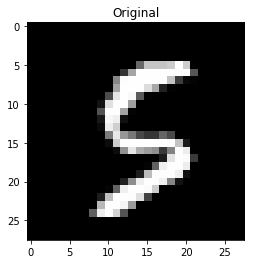

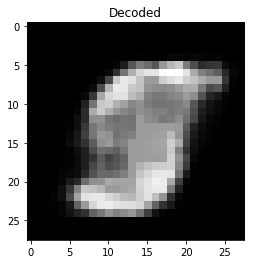

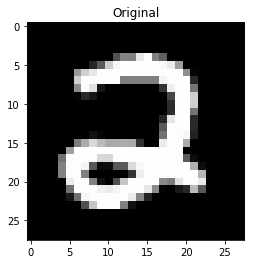

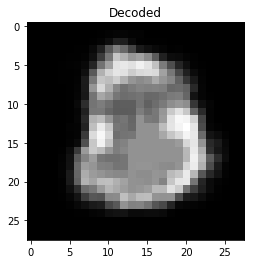

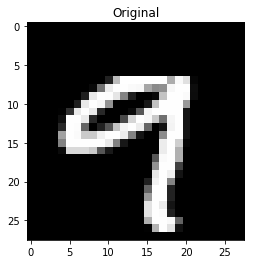

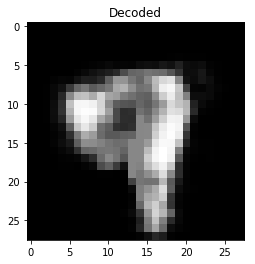

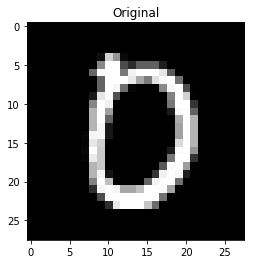

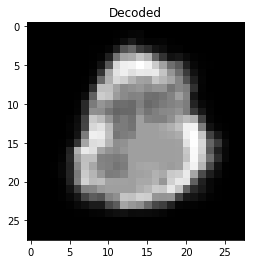

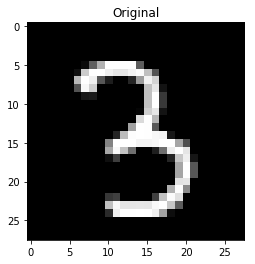

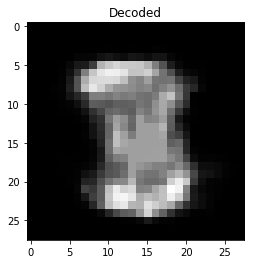

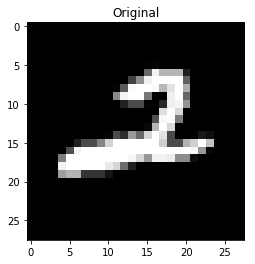

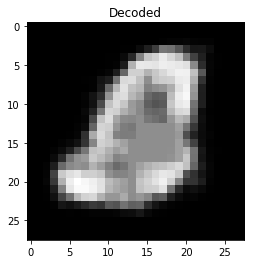

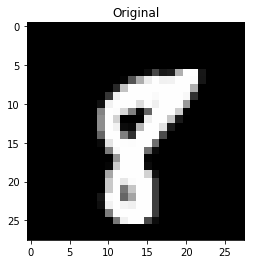

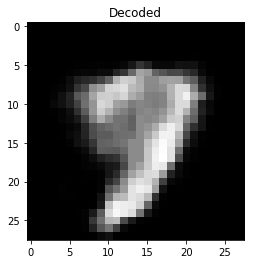

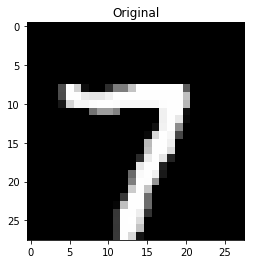

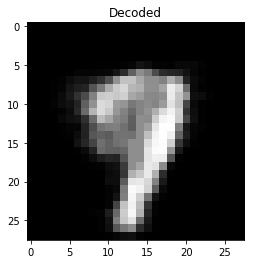

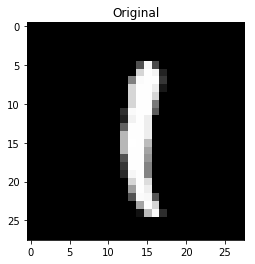

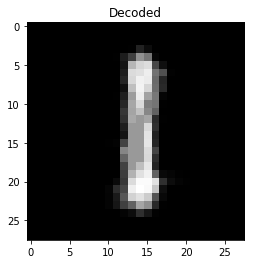

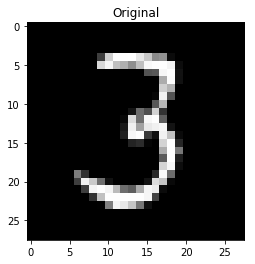

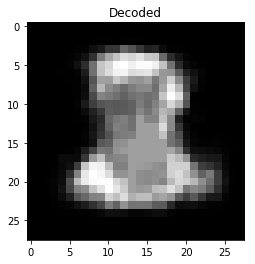

In [35]:
for i in range(10):
    idx = np.random.randint(len(X_test))
    get_eval(idx)
    print()